Aligning adult mouse coronal brain sections with the Allen Brain Atlas



In [1]:
#Import dependencies

import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd # for csv.
from matplotlib import cm
from matplotlib.lines import Line2D
import os
from os.path import exists,split,join,splitext
from os import makedirs
import glob
import requests
from collections import defaultdict
import nrrd
import torch
from torch.nn.functional import grid_sample
import tornado
import copy
import skimage
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pandas as pd

In [2]:
#Load STalign
import sys
sys.path.append("../Manjari/STalign")
from STalign import STalign

#Load file
filename = 's1r1_metadata.csv'
df = pd.read_csv(filename)

#Load x and y position
x = np.array(df['center_x'])
y = np.array(df['center_y'])
print(x,y)

[ 156.56328395  156.50928394  159.96528403 ... 9170.26188657 9086.18388439
 9073.16988405] [4271.32643177 4256.96243139 4228.18043065 ... 4431.75850555 4417.01650517
 4419.77050524]


Some stuff I don't rlly understand

In [3]:
# loading the allen atlas
url = 'http://api.brain-map.org/api/v2/data/query.csv?criteria=model::Structure,rma::criteria,[ontology_id$eq1],rma::options[order$eq%27structures.graph_order%27][num_rows$eqall]'
ontology_name,namesdict = STalign.download_aba_ontology(url, 'allen_ontology.csv') #url for adult mouse

<Response [200]>


In [4]:
imageurl = 'http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/ara_nissl/ara_nissl_50.nrrd'
labelurl = 'http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/annotation_50.nrrd'
imagefile, labelfile = STalign.download_aba_image_labels(imageurl, labelurl, 'aba_nissl.nrrd', 'aba_annotation.nrrd')

In [5]:
# Rasterize image
dx = 10
blur = 1

X_,Y_,W = STalign.rasterize(x,y,dx=dx, blur = blur,draw=False)

<IPython.core.display.Javascript object>


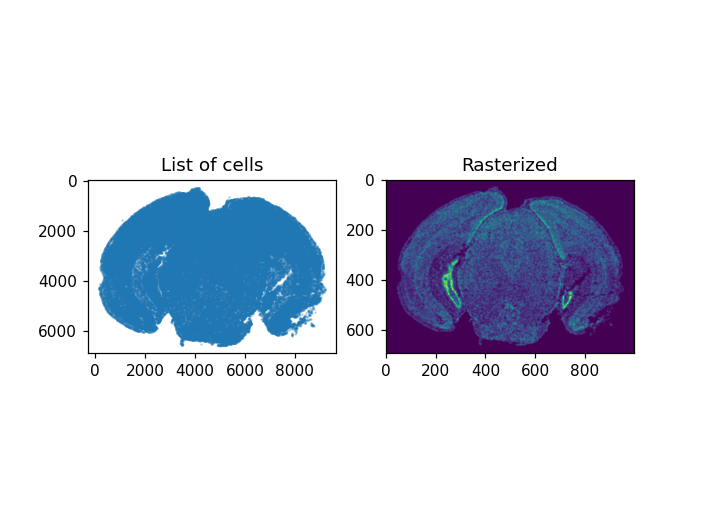

Text(0.5, 1.0, 'Rasterized')

In [6]:
#Plot unrasterized/rasterized images
fig,ax = plt.subplots(1,2)
ax[0].scatter(x,y,s=0.5,alpha=0.25)
ax[0].invert_yaxis()
ax[0].set_title('List of cells')
ax[0].set_aspect('equal')

W = W[0]
extent = (X_[0],X_[-1],Y_[0],Y_[-1])
ax[1].imshow(W,  origin='lower')
ax[1].invert_yaxis()
ax[1].set_title('Rasterized')

# save figure
#fig.canvas.draw()
#fig.savefig(outname[:-4]+'_image.png')

<IPython.core.display.Javascript object>


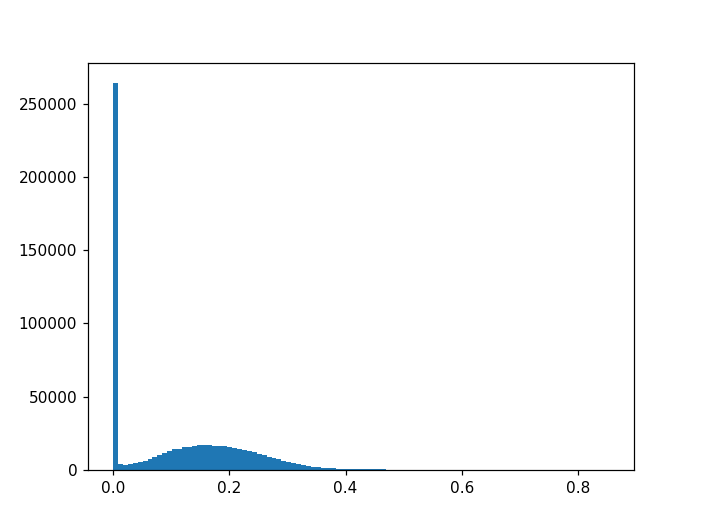

(array([2.64376e+05, 3.88100e+03, 3.65300e+03, 3.89800e+03, 4.57400e+03,
        5.31100e+03, 6.37800e+03, 7.50200e+03, 8.75200e+03, 1.00410e+04,
        1.13520e+04, 1.27840e+04, 1.40240e+04, 1.46050e+04, 1.54240e+04,
        1.57150e+04, 1.66610e+04, 1.68720e+04, 1.69470e+04, 1.68180e+04,
        1.65690e+04, 1.65410e+04, 1.61290e+04, 1.59630e+04, 1.52320e+04,
        1.45980e+04, 1.38500e+04, 1.29630e+04, 1.20320e+04, 1.11890e+04,
        1.00470e+04, 9.03500e+03, 8.09900e+03, 7.28500e+03, 6.17900e+03,
        5.24500e+03, 4.68000e+03, 3.77900e+03, 3.08000e+03, 2.68400e+03,
        2.17300e+03, 1.88300e+03, 1.42600e+03, 1.25900e+03, 1.04000e+03,
        8.60000e+02, 7.29000e+02, 6.79000e+02, 5.68000e+02, 5.17000e+02,
        4.46000e+02, 4.04000e+02, 3.43000e+02, 3.02000e+02, 3.16000e+02,
        2.73000e+02, 2.44000e+02, 2.14000e+02, 1.84000e+02, 2.18000e+02,
        1.88000e+02, 2.00000e+02, 1.89000e+02, 1.75000e+02, 1.72000e+02,
        1.71000e+02, 1.49000e+02, 1.78000e+02, 1.62

In [7]:
fig,ax = plt.subplots()
ax.hist(W.ravel(),bins=100)

<IPython.core.display.Javascript object>


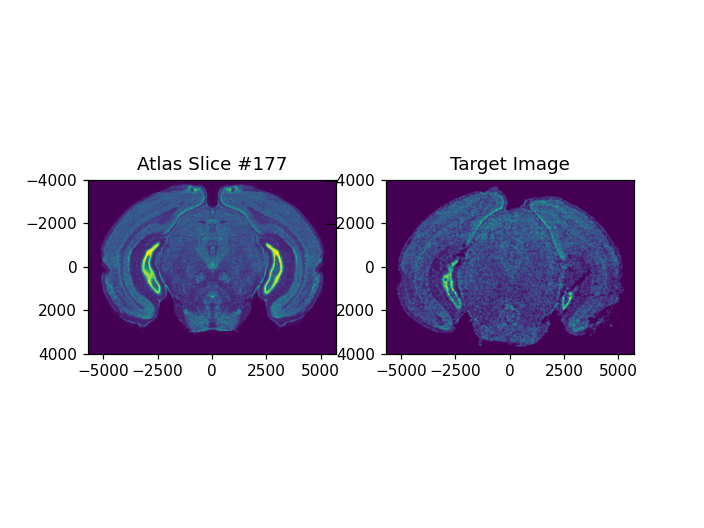

In [8]:
#find slice
#peruse through images in atlas
# Loading the atlas

slice = 177

vol,hdr = nrrd.read(imagefile)
A = vol
vol,hdr = nrrd.read(labelfile)
L = vol

dxA = np.diag(hdr['space directions'])
nxA = A.shape
xA = [np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(nxA,dxA)]
XA = np.meshgrid(*xA,indexing='ij')

fig,ax = plt.subplots(1,2)
extentA = STalign.extent_from_x(xA[1:])
ax[0].imshow(A[slice],extent=extentA)
ax[0].set_title(f'Atlas Slice #{slice}')

ax[1].imshow(W,extent=extentA)
ax[1].set_title('Target Image')
fig.canvas.draw()

In [9]:
print(W.shape)
print(A[slice+1].shape)
print([w/a for w,a in zip(W.shape,A[slice].shape)])

(696, 995)
(160, 228)
[4.35, 4.364035087719298]


<IPython.core.display.Javascript object>


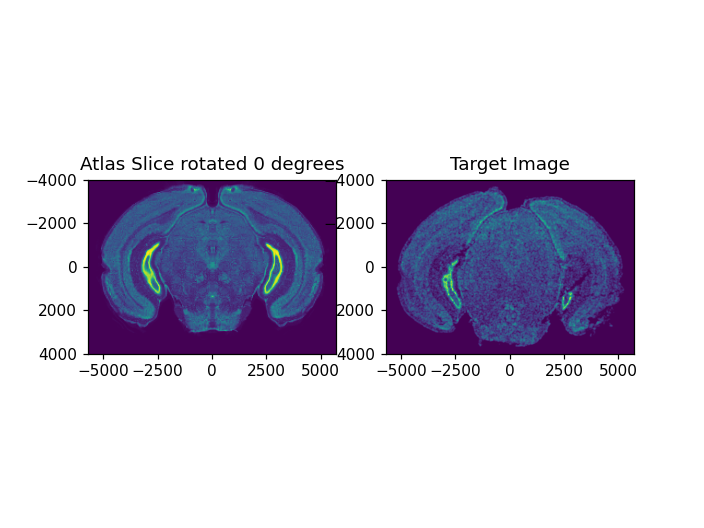

In [10]:
#find rotation
from scipy.ndimage import rotate

theta_deg = 0 # try again later with -7

fig,ax = plt.subplots(1,2)
extentA = STalign.extent_from_x(xA[1:])
ax[0].imshow(rotate(A[slice], angle=theta_deg),extent=extentA)
ax[0].set_title(f'Atlas Slice rotated {theta_deg} degrees')

ax[1].imshow(W,extent=extentA)
ax[1].set_title('Target Image')
fig.canvas.draw()

In [11]:
xJ = [Y_,X_]
J = W[None]/np.mean(np.abs(W))
xI = xA
I = A[None] / np.mean(np.abs(A),keepdims=True)
I = np.concatenate((I,(I-np.mean(I))**2))

# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

sigmaA = 2 #standard deviation of artifact intensities
sigmaB = 2 #standard deviation of background intensities
sigmaM = 2 #standard deviation of matching tissue intenities
muA = torch.tensor([3,3,3],device=device) #average of artifact intensities
muB = torch.tensor([0,0,0],device=device) #average of background intensities


<IPython.core.display.Javascript object>


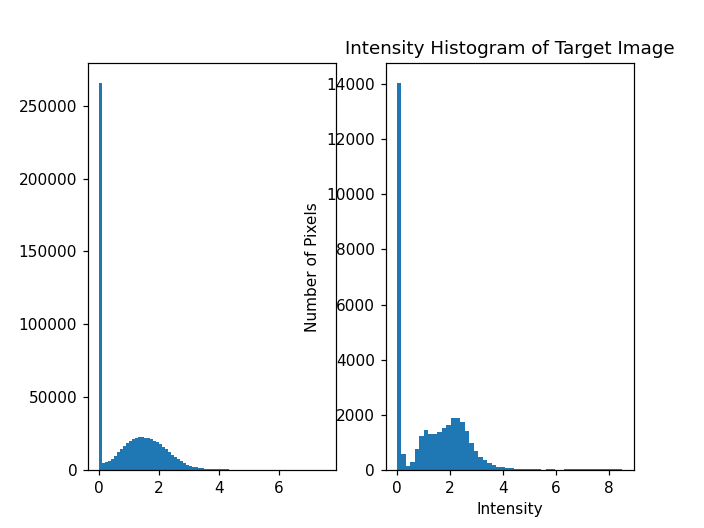

(array([1.4049e+04, 5.7400e+02, 1.4800e+02, 2.8300e+02, 7.6500e+02,
        1.2400e+03, 1.4470e+03, 1.3160e+03, 1.2940e+03, 1.3900e+03,
        1.5170e+03, 1.6450e+03, 1.8980e+03, 1.8950e+03, 1.7370e+03,
        1.4200e+03, 9.6300e+02, 6.8800e+02, 4.7300e+02, 3.5500e+02,
        2.4000e+02, 1.8900e+02, 1.1300e+02, 9.7000e+01, 6.5000e+01,
        6.4000e+01, 4.6000e+01, 3.6000e+01, 2.2000e+01, 1.7000e+01,
        1.9000e+01, 2.2000e+01, 1.5000e+01, 2.5000e+01, 2.2000e+01,
        1.3000e+01, 1.1000e+01, 1.9000e+01, 2.2000e+01, 1.9000e+01,
        2.4000e+01, 2.8000e+01, 2.1000e+01, 4.5000e+01, 4.0000e+01,
        2.7000e+01, 3.7000e+01, 4.4000e+01, 2.5000e+01, 1.6000e+01]),
 array([0.        , 0.16983625, 0.33967251, 0.50950879, 0.67934501,
        0.84918129, 1.01901758, 1.18885374, 1.35869002, 1.52852631,
        1.69836259, 1.86819875, 2.03803515, 2.2078712 , 2.37770748,
        2.54754376, 2.71738005, 2.88721633, 3.05705261, 3.2268889 ,
        3.39672518, 3.56656122, 3.7363975 , 3.

In [12]:
# Intensity Histogram
fig,ax = plt.subplots(1,2)
ax[0].hist(J.ravel(),bins=75)
plt.xlabel('Intensity')
plt.ylabel('Number of Pixels')
plt.title('Intensity Histogram of Target Image')

ax[1].hist(I[0,slice].ravel(),bins=50)

In [13]:
# initialize variables
scale_x = 0.9 #default = 0.9
scale_y = 0.9 #default = 0.9
scale_z = 0.9 #default = 0.9
theta0 = (np.pi/180)*theta_deg

# get an initial guess
if 'Ti' in locals():
    T = np.array([-xI[0][slice],np.mean(xJ[0])-(Ti[0]*scale_y),np.mean(xJ[1])-(Ti[1]*scale_x)])
else:
    T = np.array([-xI[0][slice],np.mean(xJ[0]),np.mean(xJ[1])])

scale_atlas = np.array([[scale_z,0,0],
                        [0,scale_x,0],
                        [0,0,scale_y]])
L = np.array([[1.0,0.0,0.0],
             [0.0,np.cos(theta0),-np.sin(theta0)],
              [0.0,np.sin(theta0),np.cos(theta0)]])
L = np.matmul(L,scale_atlas)#np.identity(3)

C:\Users\Manjari\.conda\envs\stalign_gpu\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<IPython.core.display.Javascript object>


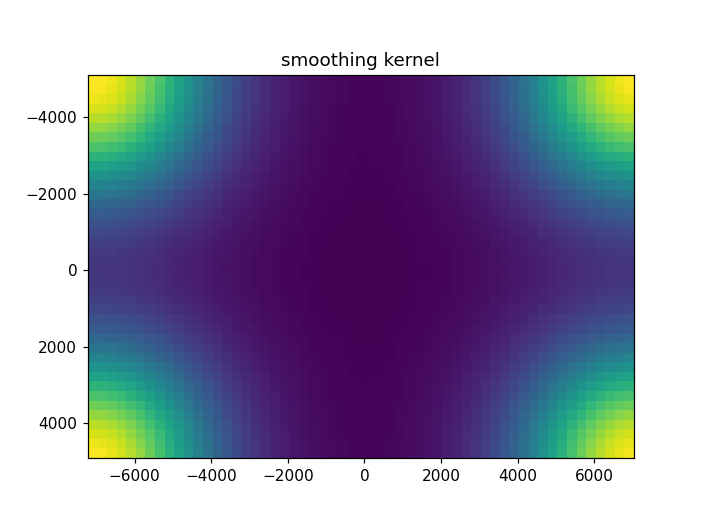

<IPython.core.display.Javascript object>


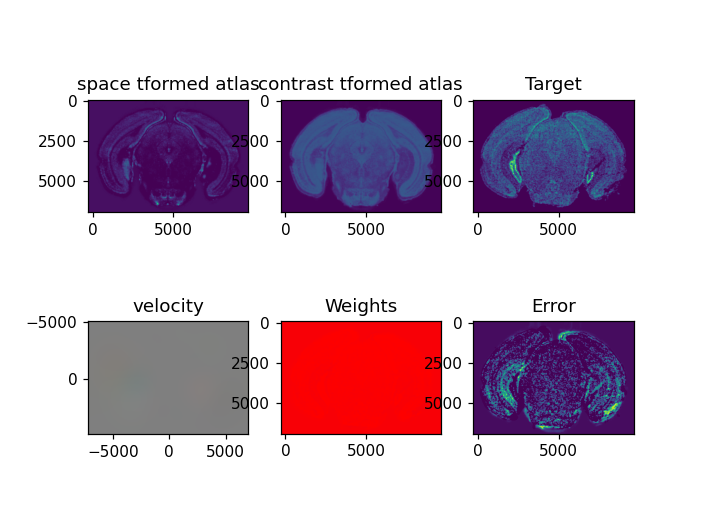

<IPython.core.display.Javascript object>


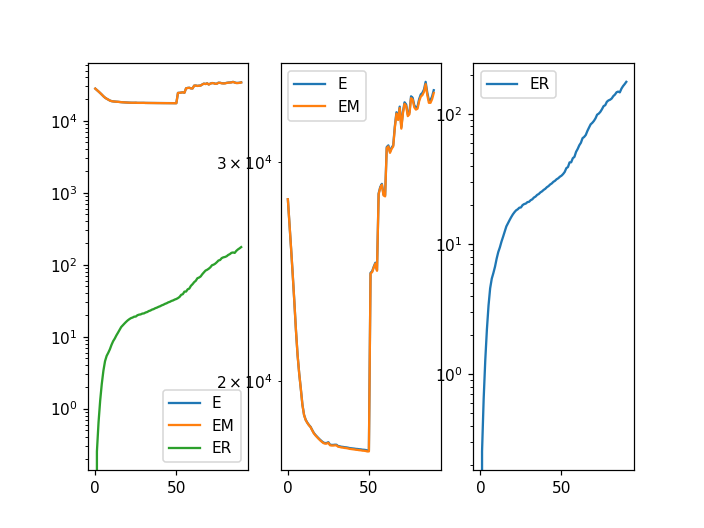

C:\Users\Manjari\Documents\Rishi\../Manjari/STalign\STalign\STalign.py:1623: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axE[2].set_yscale('log')


CPU times: total: 1min
Wall time: 13.7 s


In [14]:
%%time

#returns mat = affine transform, v = velocity, xv = pixel locations of velocity points
transform = STalign.LDDMM_3D_to_slice(
    xI,I,xJ,J,
    T=T,L=L,
    nt=4,niter=100,
    device=device,
    sigmaA = sigmaA, #standard deviation of artifact intensities
    sigmaB = sigmaB, #standard deviation of background intensities
    sigmaM = sigmaM, #standard deviation of matching tissue intenities
    muA = muA, #average of artifact intensities
    muB = muB #average of background intensities
)

In [15]:
# Saving all relavant variables
import pickle

# Saving transform
filename = 'transform_practice_1.pickle'
with open(filename,'wb') as file:
    pickle.dump(transform, file)
    print('transform check')
    pickle.dump(W,file)
    print('W check')
    pickle.dump(xJ,file)
print("stored")

transform check
W check
stored
